Epoch 0, Loss: 2.9772
Epoch 100, Loss: -0.6495
Epoch 200, Loss: -0.4618
Epoch 300, Loss: -0.3660
Epoch 400, Loss: -1.8301
Epoch 500, Loss: -1.7507
Epoch 600, Loss: -1.1770
Epoch 700, Loss: -2.1288
Epoch 800, Loss: -1.8919
Epoch 900, Loss: -1.2159


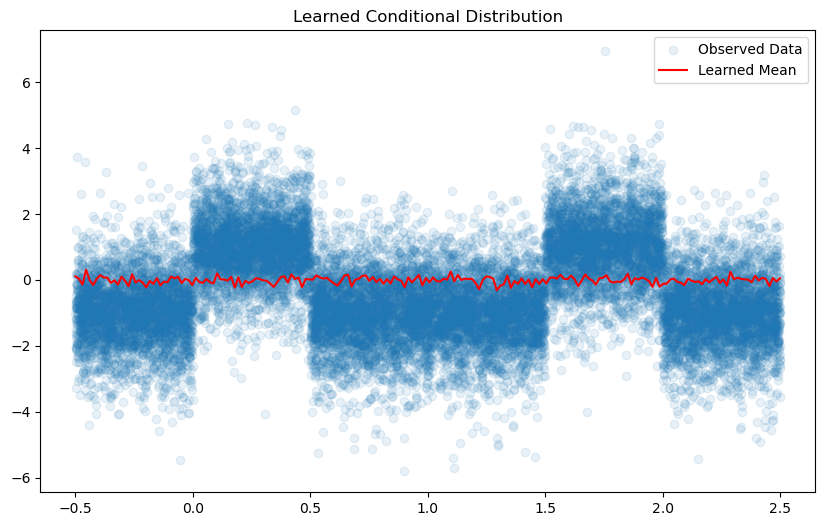

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

class ConditionalNormalizingFlowV2(nn.Module):
     
    def __init__(self, condition_dim, target_dim, hidden_dims=[128, 128, 128]):
        super().__init__()
        
        self.base_dist = torch.distributions.Normal(0, 1)
        
        layers = []
        prev_dim = condition_dim + target_dim
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU()
            ])
            prev_dim = hidden_dim
        
        # Networks for scale and shift
        self.scale_net = nn.Sequential(
            *layers,
            nn.Linear(prev_dim, target_dim),
            nn.Softplus()  # Ensure positivity
        )
        self.shift_net = nn.Sequential(
            *layers,
            nn.Linear(prev_dim, target_dim)
        )
    
    def forward(self, condition, target):
        inp = torch.cat([condition, target], dim=-1)
        scale = self.scale_net(inp) + 1e-6
        shift = self.shift_net(inp)
        
        z = (target - shift) / scale
        log_prob = self.base_dist.log_prob(z).sum(-1)
        log_det = -torch.log(scale).sum(-1)
        
        return log_prob + log_det
    
    def sample(self, condition, num_samples=1):
        condition = condition.repeat(num_samples, 1)
        z = self.base_dist.sample((num_samples, condition.shape[1])).to(condition.device)
        
        inp = torch.cat([condition, z], dim=-1)
        scale = self.scale_net(inp) + 1e-6
        shift = self.shift_net(inp)
        
        return z * scale + shift


def train_conditional_flow_v2(conditions, targets, epochs=1000, lr=1e-3):
    """
    Train the improved conditional normalizing flow.
    """
    model = ConditionalNormalizingFlowV2(condition_dim=1, target_dim=1)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        loss = -model(conditions, targets).mean()
        loss.backward()
        optimizer.step()
        
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")
    
    return model


# Prepare the data
n_samples = 20000
y = np.random.uniform(-0.5, 2.5, n_samples)
X = y.reshape(-1, 1)
xtrue = np.zeros_like(y)

for i in range(len(xtrue)):
    if (0 < y[i] < 0.5) or (1.5 < y[i] < 2):
        xtrue[i] = np.random.normal(1, scale=0.0000005)
    else:
        xtrue[i] = np.random.normal(-1, scale=0.0000005)

obs_noise_std = np.random.uniform(0.5, 1.5, len(xtrue))
x = xtrue + np.random.normal(0, obs_noise_std, len(xtrue))

# Convert to torch tensors
conditions = torch.FloatTensor(X)
targets = torch.FloatTensor(x).unsqueeze(-1)

# Train the model
trained_model = train_conditional_flow_v2(conditions, targets)

# Visualize results
def visualize_flow_results(model, conditions, targets):
    """
    Visualize the results of the improved conditional normalizing flow.
    """
    with torch.no_grad():
        test_conditions = torch.linspace(-0.5, 2.5, 200).unsqueeze(-1)
        samples_list = []
        for cond in test_conditions:
            samples = model.sample(cond, num_samples=100)
            samples_list.append(samples.numpy())
        
        samples_array = np.array(samples_list).squeeze()

    plt.figure(figsize=(10, 6))
    plt.title("Learned Conditional Distribution")
    plt.scatter(conditions.numpy(), targets.numpy(), alpha=0.1, label="Observed Data")
    plt.plot(test_conditions.numpy(), samples_array.mean(axis=1), color="red", label="Learned Mean")
    plt.legend()
    plt.show()


visualize_flow_results(trained_model, conditions, targets)


In [1]:
from cde.density_simulation import SkewNormal
from cde.density_estimator import KernelMixtureNetwork
import numpy as np

""" simulate some data """
density_simulator = SkewNormal(random_seed=22)
X, Y = density_simulator.simulate(n_samples=3000)

""" fit density model """
model = KernelMixtureNetwork("KDE_demo", ndim_x=1, ndim_y=1, n_centers=50,
                             x_noise_std=0.2, y_noise_std=0.1, random_seed=22)
model.fit(X, Y)

""" query the conditional pdf and cdf """
x_cond = np.zeros((1, 1))
y_query = np.ones((1, 1)) * 0.1
prob = model.pdf(x_cond, y_query)
cum_prob = model.cdf(x_cond, y_query)

""" compute conditional moments & VaR  """
mean = model.mean_(x_cond)[0][0]
std = model.std_(x_cond)[0][0]
skewness = model.skewness(x_cond)[0]

ModuleNotFoundError: No module named 'cde'

In [1]:
import torch
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam


c:\Document\Serieux\Travail\conda_env\ml\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(42)

# True parameters
beta_true = torch.tensor([2.0, -1.0])  # True coefficients
sigma_true = 0.5  # True noise standard deviation

# Generate data
n_samples = 100
X = torch.randn(n_samples, 2)  # Predictor variables
y = X @ beta_true + sigma_true * torch.randn(n_samples)  # Response variable


In [3]:
def model(X, y=None):
    # Priors
    beta = pyro.sample("beta", dist.Normal(torch.zeros(2), torch.ones(2)))  # Coefficients
    sigma = pyro.sample("sigma", dist.Exponential(1.0))  # Noise scale
    
    # Likelihood
    with pyro.plate("data", X.shape[0]):
        mean = X @ beta
        pyro.sample("obs", dist.Normal(mean, sigma), obs=y)


In [4]:
def guide(X, y=None):
    # Variational parameters for beta
    beta_loc = pyro.param("beta_loc", torch.zeros(2))
    beta_scale = pyro.param("beta_scale", torch.ones(2), constraint=torch.distributions.constraints.positive)
    beta = pyro.sample("beta", dist.Normal(beta_loc, beta_scale))
    
    # Variational parameters for sigma
    sigma_loc = pyro.param("sigma_loc", torch.tensor(1.0), constraint=torch.distributions.constraints.positive)
    sigma = pyro.sample("sigma", dist.Exponential(sigma_loc))


In [5]:
optimizer = Adam({"lr": 0.01})  # Learning rate
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())


In [8]:
from pyro.infer import SVGD, RBFSteinKernel
from pyro.optim import Adam

kernel = RBFSteinKernel()
adam = Adam({"lr": 0.1})
svgd = SVGD(model, kernel, adam, num_particles=50, max_plate_nesting=0)

for step in range(500):
    svgd.step(model_arg1, model_arg2)

final_particles = svgd.get_named_particles()

NameError: name 'model_arg1' is not defined